# OmniFold with ALEPH Open Data

### Imports

In [17]:
import os

import energyflow as ef
import energyflow.archs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot

import omnifold
import modplot
import ibu_BADEA_STUDIES as ibu

### Plot Style

In [18]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

## Loading the Data

In [6]:
aleph_path = '/callisto/ALEPH'

# load data, currently just get thrust values
thrust_arrs = []
years = ['1992', '1993', '1994', '1995']
eSels = ['passesNTupleAfterCut',
         'passesTotalChgEnergyMin', 
         'passesNTrkMin', 
         'passesNeuNch',
         'passesSTheta']

for year in years:
    data_file = uproot.open(os.path.join(aleph_path, 'LEP1Data{}_recons_aftercut-MERGED.root'.format(year)))
    event_mask = np.ones(len(data_file['t']['EventNo'])) 
    for eSel in eSels:
        event_mask *= data_file['t'][eSel].array()
    event_mask = np.array(event_mask).astype(bool)
    thrust_arrs.append(data_file['t']['Thrust'].array()[event_mask])
    
# dictionary to hold observable values
nature = {'data_thrusts': np.concatenate(thrust_arrs)}

# load mc, currently just get thrust values
mc_file = uproot.open(os.path.join(aleph_path, 'alephMCRecoAfterCutPaths_1994.root'))
event_mask = np.ones(len(mc_file['t']['EventNo'])) 
for eSel in eSels:
    event_mask *= mc_file['t'][eSel].array()
event_mask = np.array(event_mask).astype(bool)
synthetic = {'gen_thrusts': mc_file['tgen']['Thrust'].array()[event_mask], # removed 1 - before all three
             'genBefore_thrusts': mc_file['tgenBefore']['Thrust'].array(),
             'sim_thrusts': mc_file['t']['Thrust'].array()[event_mask]}

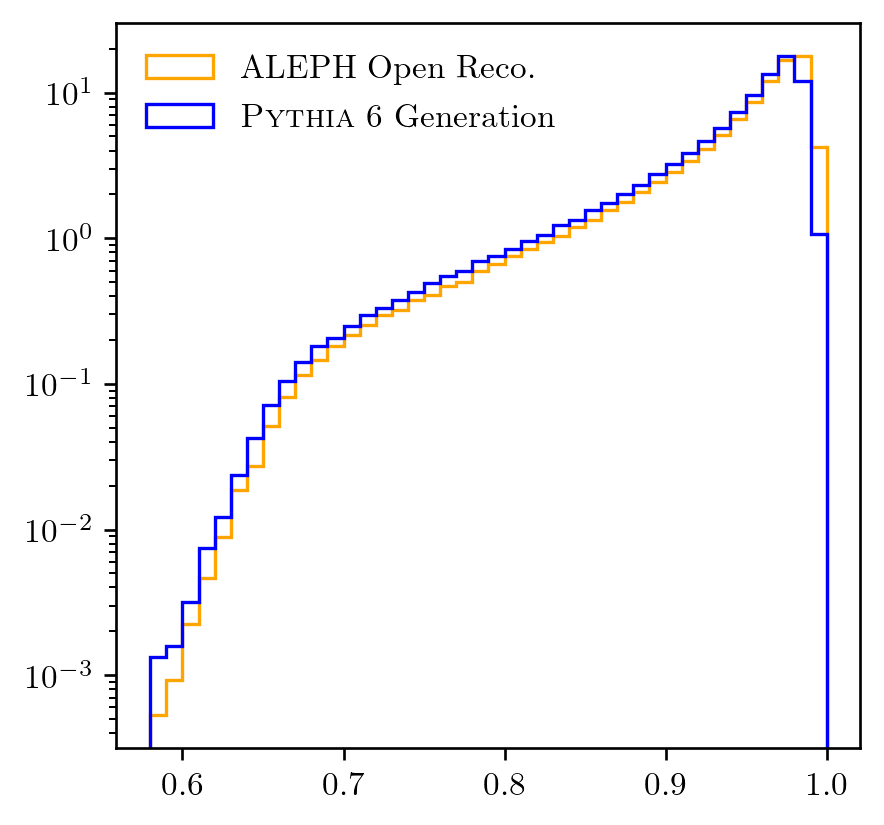

In [126]:
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(0, 0.5, 51)

# ANTHONY TEST
# binsTEST = np.linspace(0,0.42,43)
binsTEST = np.linspace(0.58, 1.0, 43)

density = True

#plt.hist(nature['data_thrusts'], bins=bins, histtype='step', color='black', density=density)
simhist = plt.hist(synthetic['sim_thrusts'], bins=binsTEST, label='ALEPH Open Reco.', histtype='step', color='orange', density=density)[0]
genhist = plt.hist(synthetic['gen_thrusts'], bins=binsTEST, label=r'\textsc{Pythia} 6 Generation', histtype='step', color='blue', density=density)[0]
#genbhist = plt.hist(synthetic['genBefore_thrusts'], bins=binsTEST, histtype='step', color='green', density=density)[0]

plt.yscale('log')
plt.legend(loc="upper left", frameon=False)
plt.savefig("IBUStudy/truth_reco.pdf")
plt.show()

## Specifying the Unfolding Problem

In [79]:
# how many iterations of the unfolding process
itnum = 3

# the observables to use for multifold (a single one just indicates unifold)
obs_multifold = ['Thrust']

# a dictionary to hold information about the observables
obs = {}

# the thrust and histogram style information
obs.setdefault('Thrust', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_thrusts'],
    'nbins_det': 42, 'nbins_mc': 42, # 'nbins_det': 50, 'nbins_mc': 50,
    'yscale': 'log',
    'xlim': (0.58, 1.0), 'ylim': (0.5*10**-3, 20), 'ylim_ratio': (0.7, 1.3),
    'ytick_ratio_step': 0.15,
    'xlabel': r'Thrust', 'symbol': r'T',
    'ylabel': r'Normalized Cross Section', 'ylabel_ratio': 'Ratio to\nTruth',
    'stamp_xy': (0.1, 0.9),
    'legend_loc': 'lower right', 'legend_ncol': 1
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': r'\textsc{Pythia} 6 Generation'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': 'ALEPH Measurement'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

In [96]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['dataobs'] = ob['func'](nature, 'data')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'],  ob['ibu_ms'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = [ibu.ibu_unc(ob, it=i, nresamples=25) for i in range(itnum+1)]
    
    print('Done with', obkey)

Done with Thrust


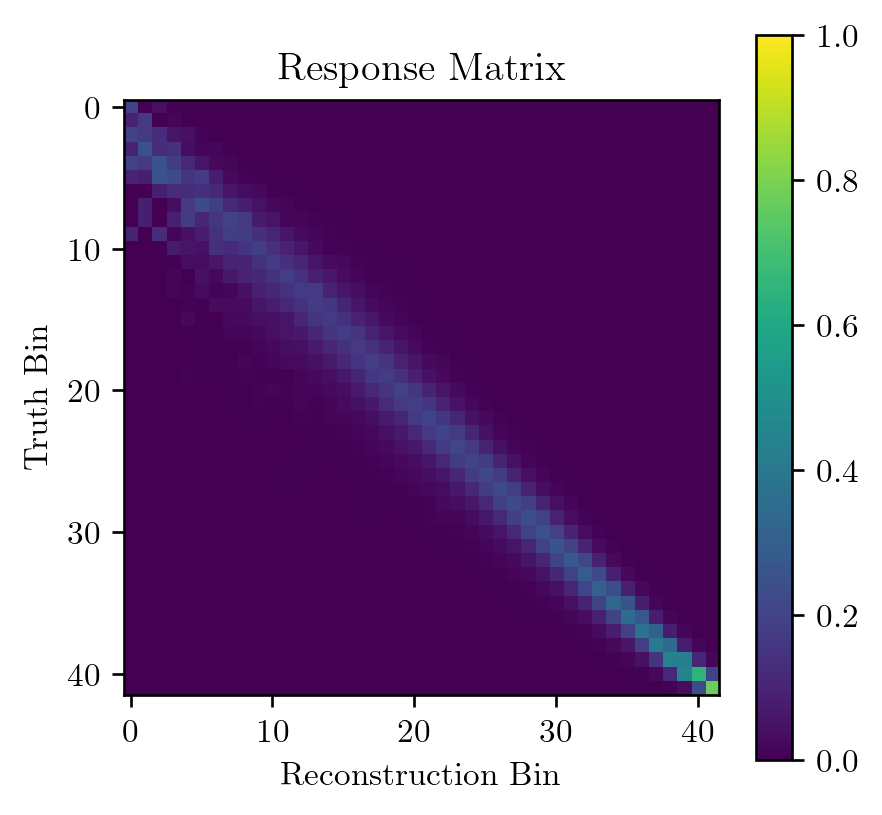

In [122]:
plt.imshow(obs['Thrust']['response'], vmin = 0, vmax = 1)
plt.xlabel("Reconstruction Bin")
plt.ylabel("Truth Bin")
plt.title("Response Matrix")
plt.colorbar()
plt.savefig("IBUStudy/response.pdf")
plt.show()

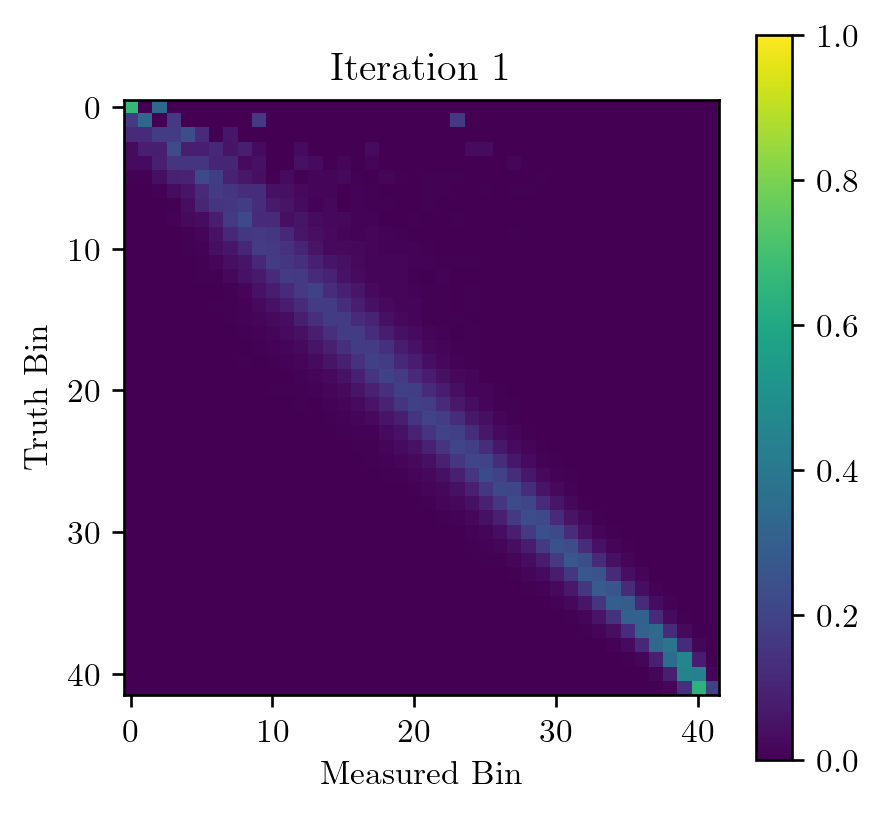

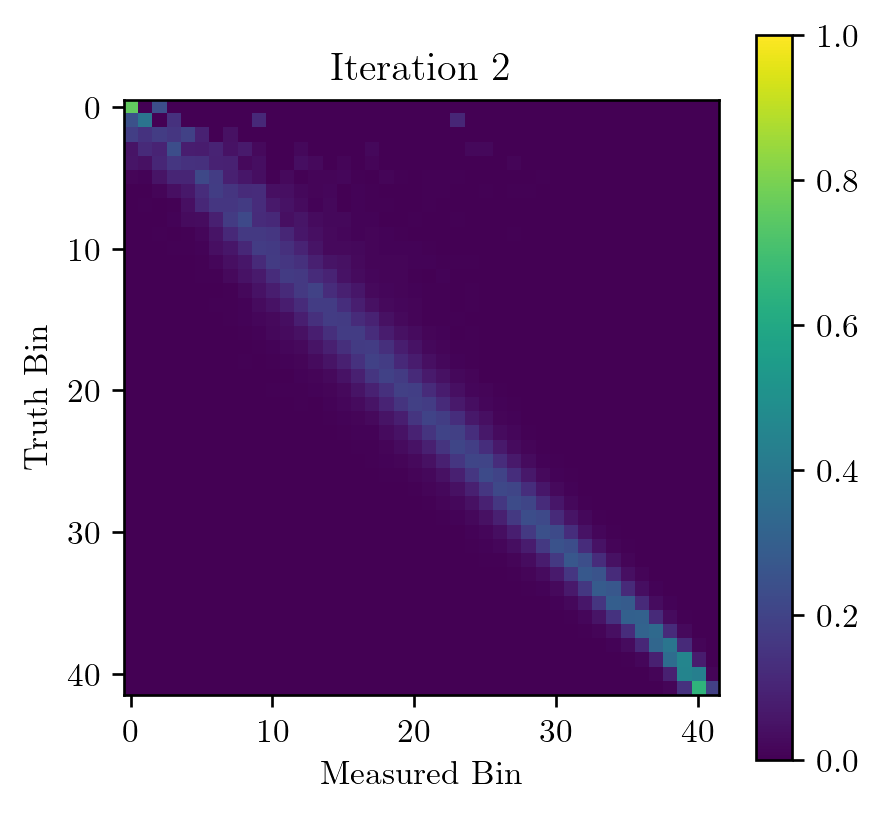

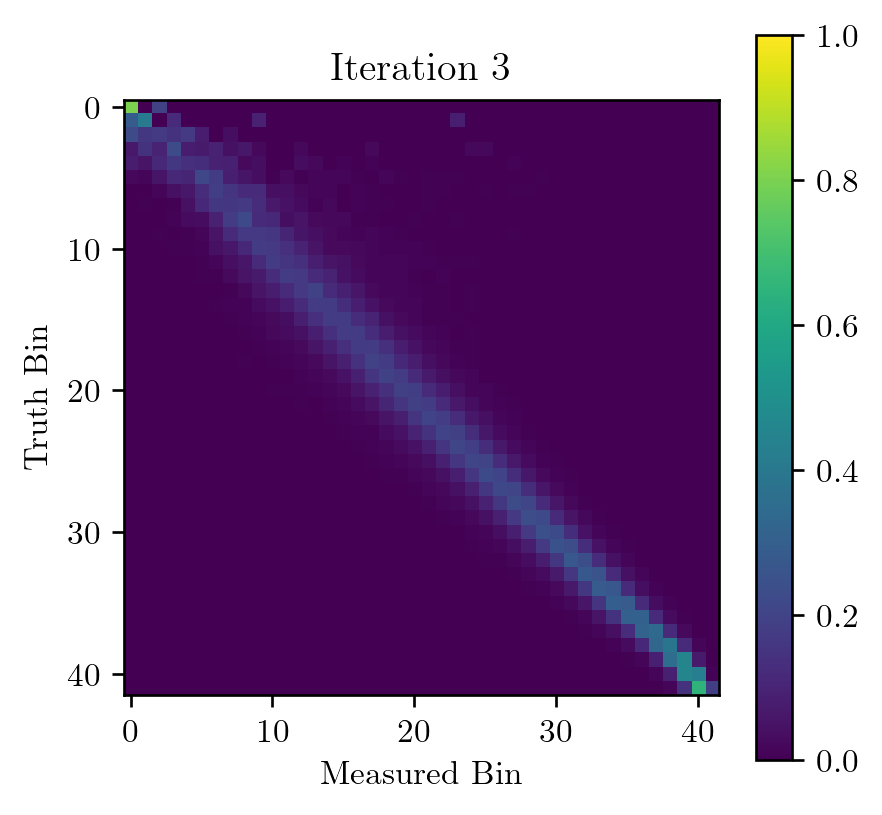

In [120]:
i = 1
for ibu_ms in obs['Thrust']['ibu_ms']:
    plt.imshow(ibu_ms, vmin = 0, vmax = 1)
    plt.xlabel("Measured Bin")
    plt.ylabel("Truth Bin")
    plt.title("Iteration %i"%i)
    plt.colorbar()
    plt.savefig("IBUStudy/ibu_ms_iter_%i.pdf"%i)
    plt.show()
    i+=1

## Plot Unfolding Results

In [98]:
with open('HEPData-ins636645-v1-Table_54.csv', 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [99]:
corrs = genbhist/(genhist + 10**-50)

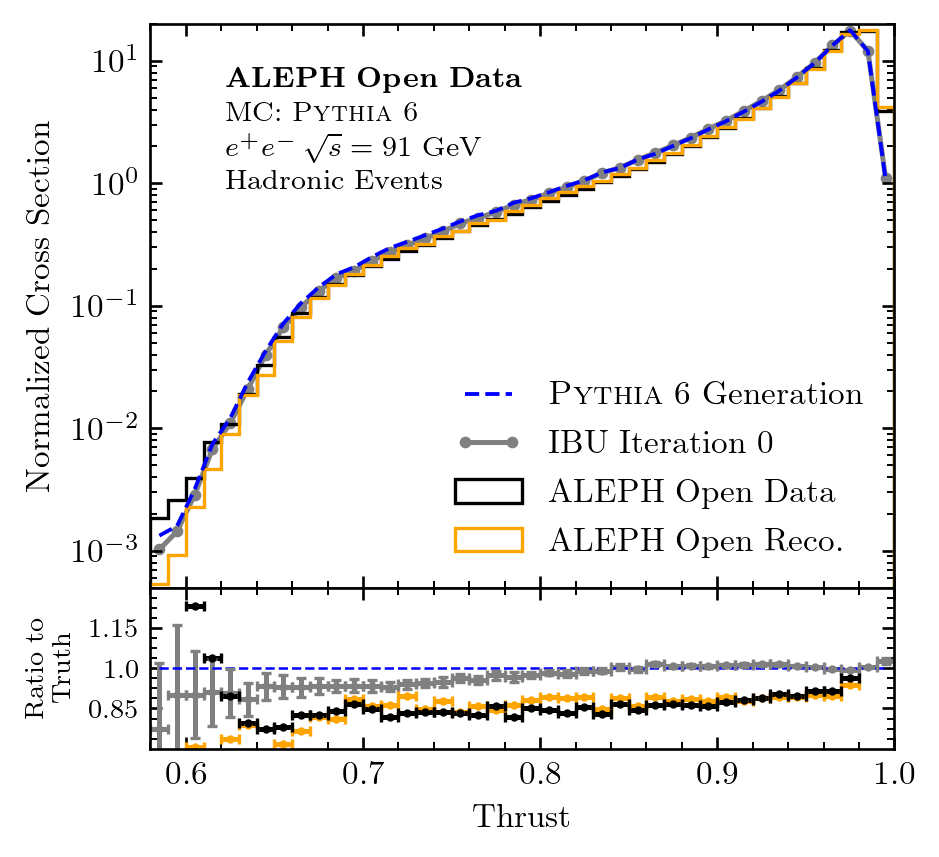

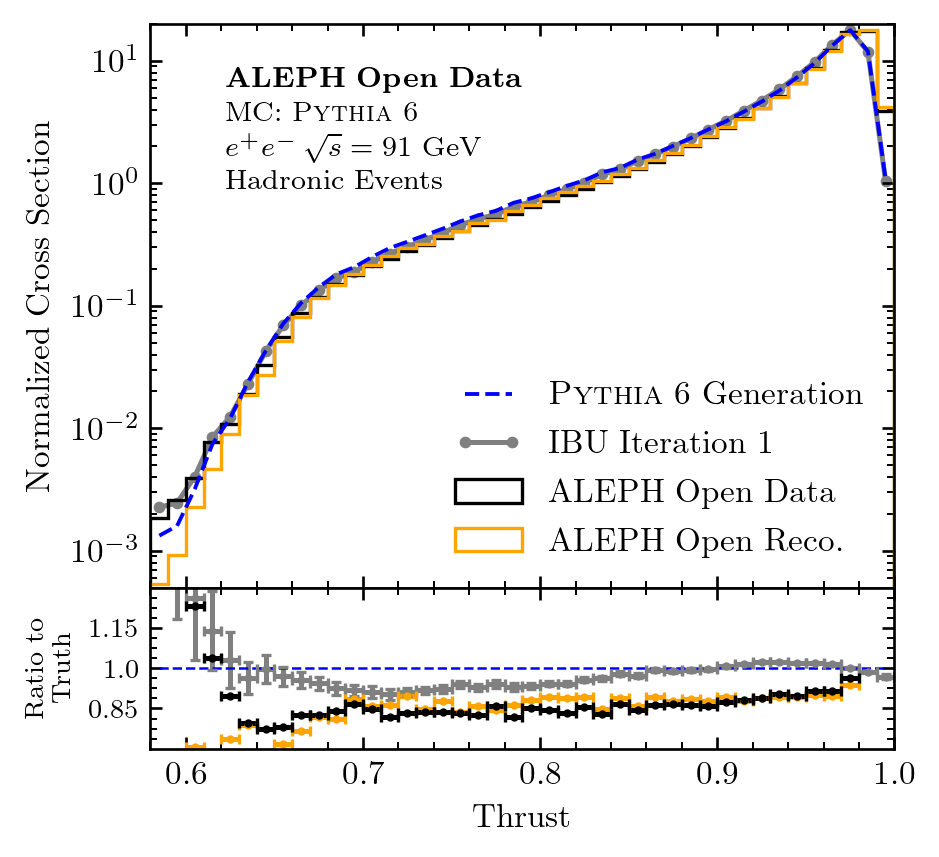

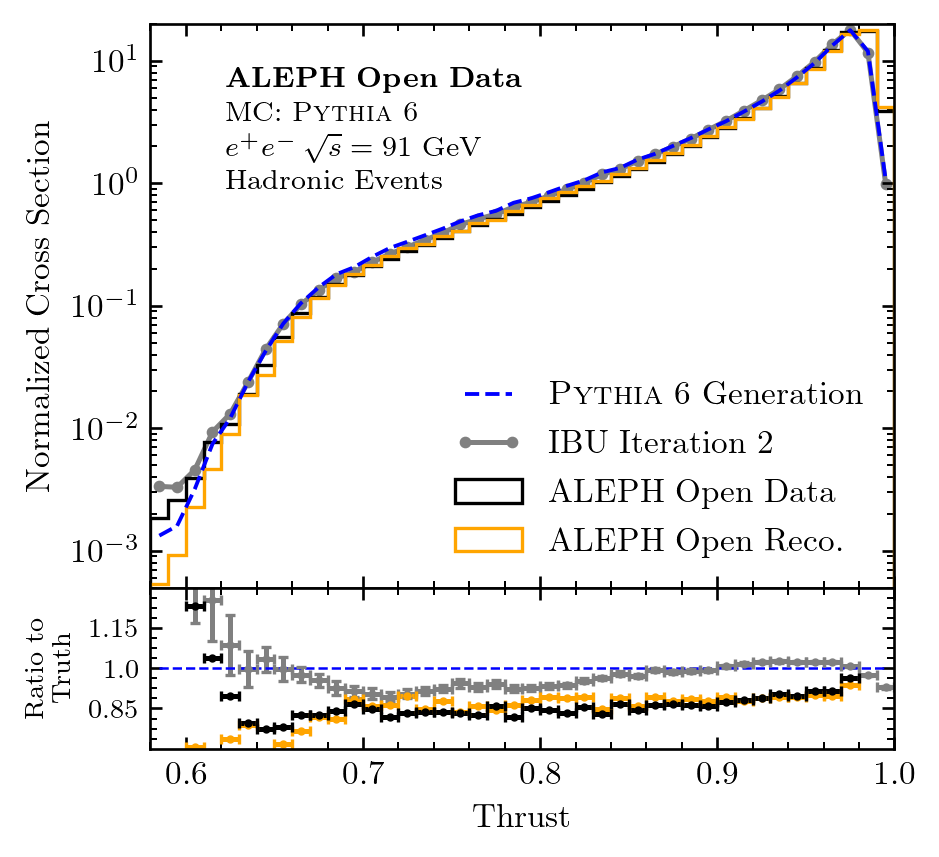

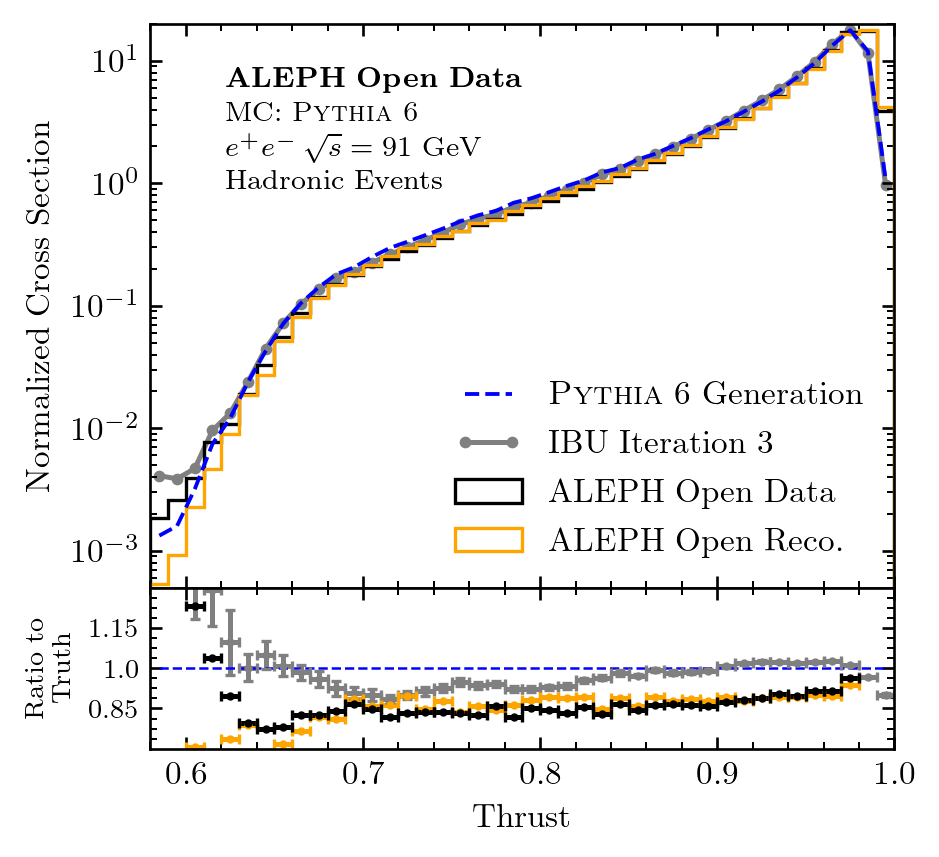

In [103]:
for it in range(itnum+1):
    for i,(obkey,ob) in enumerate(obs.items()):
        # get the styled axes on which to plot
        fig, [ax0, ax1] = modplot.axes(**ob)


        #############################################################################################
        # plot the "data" histogram of the observable
        data_hist = ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='ALEPH Open Data', **hist_style)[0]
        # plot the "sim" histogram of the observable
        reco_hist = ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='ALEPH Open Reco.', **hist_style)[0]
        # plot the "gen" histogram of the observable
        ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
        # plot the IBU distribution before and after correction
        ibu_hist_corr = ob['ibu_phis'][it]*corrs
        ax0.plot(ob['midbins_mc'], ibu_hist_corr, **ibu_style, label='IBU Iteration {}'.format(it))
        #############################################################################################





        #############################################################################################
        # Compute ratios
        ibu_ratio_hist_corr = ibu_hist_corr/(ob['genobs_hist'] + 10**-50)
        data_ratio = data_hist/(ob['genobs_hist'] + 10**-50)
        reco_ratio = reco_hist/(ob['genobs_hist'] + 10**-50)

        # ratio uncertainties
        ibu_unc_ratio = ob['ibu_phi_unc'][it]/(ob['genobs_hist'] + 10**-50)
        ibu_unc_ratio_corr = ibu_unc_ratio*corrs1


        ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='blue', lw=0.75)
        ax1.errorbar(ob['midbins_mc'], ibu_ratio_hist_corr, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio_corr, color=ibu_style['color'], **modplot.style('errorbar'))
        ax1.errorbar(ob['midbins_mc'], reco_ratio, xerr=ob['binwidth_mc']/2, color='orange', **modplot.style('errorbar'))
        ax1.errorbar(ob['midbins_mc'], data_ratio, xerr=ob['binwidth_mc']/2, color='black', **modplot.style('errorbar'))
        #############################################################################################




        #############################################################################################
        ax0.set_yscale(ob['yscale'])
        # legend style and ordering
        loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
        order = range(4)
        modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

        # stamp to put on the plots
        modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                      line_0=r'\textbf{ALEPH Open Data}',
                      line_1=r'MC: \textsc{Pythia 6}',
                      line_2=r'$e^+e^-\,\sqrt{s}=91$ GeV',
                      line_3='Hadronic Events')

        # save plot (by default in the same directory as this notebook).
        # If running on binder, the plot can be accessed by first going to the jupyter file browser
        # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
        # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
        fig.savefig('IBUStudy/IBU_{}_Iter_{}.pdf'.format(obkey,it), bbox_inches='tight')
        plt.show()
        #############################################################################################

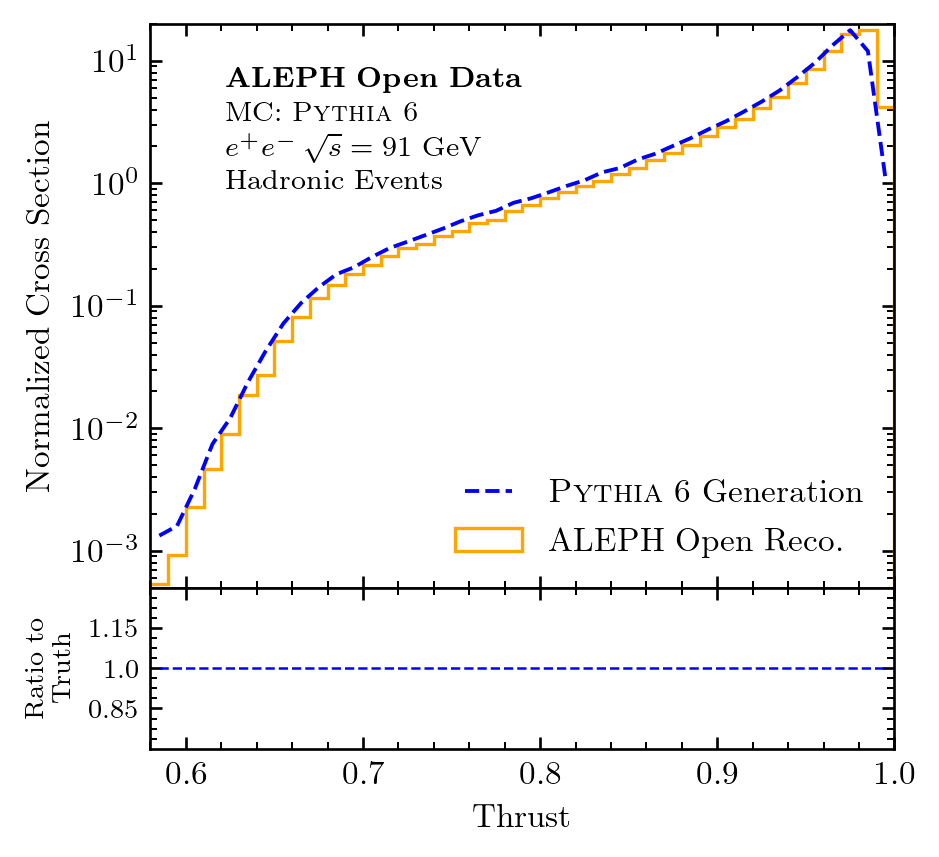

In [133]:
for i,(obkey,ob) in enumerate(obs.items()):
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)


    #############################################################################################
    # plot the "data" histogram of the observable
    #data_hist = ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='ALEPH Open Data', **hist_style)[0]
    # plot the "sim" histogram of the observable
    reco_hist = ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='ALEPH Open Reco.', **hist_style)[0]
    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    # plot the IBU distribution before and after correction
    ibu_hist_corr = ob['ibu_phis'][it]*corrs
    #ax0.plot(ob['midbins_mc'], ibu_hist_corr, **ibu_style, label='IBU Iteration {}'.format(it))
    #############################################################################################





    #############################################################################################
    # Compute ratios
    ibu_ratio_hist_corr = ibu_hist_corr/(ob['genobs_hist'] + 10**-50)
    data_ratio = data_hist/(ob['genobs_hist'] + 10**-50)
    reco_ratio = reco_hist/(ob['genobs_hist'] + 10**-50)

    # ratio uncertainties
    ibu_unc_ratio = ob['ibu_phi_unc'][it]/(ob['genobs_hist'] + 10**-50)
    ibu_unc_ratio_corr = ibu_unc_ratio*corrs1


    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='blue', lw=0.75)
    #ax1.errorbar(ob['midbins_mc'], ibu_ratio_hist_corr, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio_corr, color=ibu_style['color'], **modplot.style('errorbar'))
    #ax1.errorbar(ob['midbins_mc'], reco_ratio, xerr=ob['binwidth_mc']/2, color='orange', **modplot.style('errorbar'))
    #ax1.errorbar(ob['midbins_mc'], data_ratio, xerr=ob['binwidth_mc']/2, color='black', **modplot.style('errorbar'))
    #############################################################################################




    #############################################################################################
    ax0.set_yscale(ob['yscale'])
    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = range(2)
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{ALEPH Open Data}',
                  line_1=r'MC: \textsc{Pythia 6}',
                  line_2=r'$e^+e^-\,\sqrt{s}=91$ GeV',
                  line_3='Hadronic Events')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('IBUStudy/MCDistributions.pdf', bbox_inches='tight')
    plt.show()
    #############################################################################################